# Learning Algorithms for Graph Neural Networks: Part 1

In this notebook, we'll explore the theoretical foundations and implementation of gradient-based learning algorithms for Graph Neural Networks (GNNs) as described in the seminal paper by Scarselli et al. We'll focus on understanding how learning works in GNNs, including the specialized backpropagation algorithm and the importance of enforcing the contraction mapping property.

## 1. Introduction to Learning in GNNs

Learning in GNNs involves finding the optimal parameters for two key functions:

1. **Transition function (f)**: Defines how information propagates between nodes in a graph
2. **Output function (g)**: Maps the final node states to the desired output

The learning process must account for two critical aspects that differentiate GNNs from conventional neural networks:

- **Recursive nature**: Node states depend on their neighbors' states, creating a recursive dependency
- **Convergence requirement**: The transition function must be a contraction mapping to ensure convergence to a fixed point

In this notebook, we'll implement the algorithms described in the Scarselli et al. paper, which adapts backpropagation to handle these unique challenges.

## 2. Theoretical Background

### 2.1 The Recursive Update Equation

In GNNs, node states are updated according to the following recursive equation:

$$x_n = f(l_n, l_{co[n]}, x_{ne[n]}, l_{ne[n]}, w)$$

Where:
- $x_n$ is the state of node $n$
- $l_n$ is the label/features of node $n$
- $l_{co[n]}$ is the label/features of the edges connected to node $n$
- $x_{ne[n]}$ are the states of the neighbors of node $n$
- $l_{ne[n]}$ are the labels/features of the neighbors of node $n$
- $w$ are the parameters of the transition function

After the node states converge to a fixed point $\bar{x}$, the output for each node is computed as:

$$o_n = g(\bar{x}_n, l_n, w)$$

Where $g$ is the output function and $w$ are its parameters.

### 2.2 Learning Objective

The learning objective is to minimize the error between the computed outputs and the target outputs:

$$e(w) = \sum_{i=1}^p \sum_{n \in N_i} (t_{i,n} - o_{i,n})^2$$

Where:
- $p$ is the number of graphs in the training set
- $N_i$ is the set of nodes in graph $i$
- $t_{i,n}$ is the target output for node $n$ in graph $i$
- $o_{i,n}$ is the computed output for node $n$ in graph $i$

### 2.3 Contraction Mapping Requirement

For the recursive update to converge, the transition function must be a contraction mapping, meaning:

$$\| f(x) - f(y) \| \leq \mu \| x - y \|$$

Where $\mu < 1$ is the contraction coefficient. This property ensures that the recursive application of $f$ will converge to a unique fixed point.

## 3. Implementation of the GNN Model with Learning Components

Let's implement the core GNN model with the components necessary for learning:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

class ContractionConstrainedGNN(nn.Module):
    """
    A GNN implementation with constraints to ensure the transition function is a contraction mapping.
    """
    def __init__(self, node_features, edge_features, hidden_dim, output_dim, 
                 max_iterations=100, tolerance=1e-6, contraction_penalty=1.0):
        super(ContractionConstrainedGNN, self).__init__()
        
        self.node_features = node_features
        self.edge_features = edge_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.contraction_penalty = contraction_penalty
        
        # Transition function layers
        self.transition_mlp = nn.Sequential(
            nn.Linear(node_features + edge_features + hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )
        
        # Output function layers
        self.output_mlp = nn.Sequential(
            nn.Linear(hidden_dim + node_features, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        
        # Initialize weights to ensure initial contraction
        self._initialize_weights()
    
    def _initialize_weights(self):
        """
        Initialize weights to ensure the transition function starts as a contraction mapping.
        This is done by keeping the weights small enough to ensure the Lipschitz constant < 1.
        """
        for layer in self.transition_mlp:
            if isinstance(layer, nn.Linear):
                # Scale down the weights by a factor to ensure contraction
                scale = 0.5 / np.sqrt(layer.in_features)
                nn.init.uniform_(layer.weight, -scale, scale)
                nn.init.zeros_(layer.bias)
    
    def transition_function(self, node_features, edge_indices, edge_features, node_states):
        """
        The transition function that updates node states based on neighboring nodes.
        
        Args:
            node_features: Features of each node (N x F_n)
            edge_indices: Connectivity of the graph as edge list (2 x E)
            edge_features: Features of each edge (E x F_e)
            node_states: Current state of each node (N x H)
            
        Returns:
            New node states
        """
        num_nodes = node_features.size(0)
        new_states = torch.zeros_like(node_states)
        
        # For each node, aggregate information from its neighbors
        for i in range(num_nodes):
            # Find incoming edges (neighbors -> i)
            mask = edge_indices[1] == i
            neighbor_indices = edge_indices[0][mask]
            edge_indices_i = mask.nonzero().squeeze(-1)
            
            if len(neighbor_indices) == 0:
                # If no neighbors, just use the node's own features
                combined_features = torch.cat([
                    node_features[i],
                    torch.zeros(self.edge_features, device=node_features.device),
                    torch.zeros(self.hidden_dim, device=node_features.device)
                ])
                new_states[i] = self.transition_mlp(combined_features.unsqueeze(0)).squeeze(0)
            else:
                # Aggregate features from neighbors
                neighbor_states = node_states[neighbor_indices]
                neighbor_edge_features = edge_features[edge_indices_i]
                
                # If multiple neighbors, average their contribution
                if len(neighbor_indices) > 1:
                    neighbor_states = neighbor_states.mean(dim=0, keepdim=True)
                    neighbor_edge_features = neighbor_edge_features.mean(dim=0, keepdim=True)
                
                # Combine features and compute new state
                combined_features = torch.cat([
                    node_features[i].unsqueeze(0),
                    neighbor_edge_features,
                    neighbor_states
                ], dim=1)
                
                new_states[i] = self.transition_mlp(combined_features).squeeze(0)
        
        return new_states
    
    def output_function(self, node_states, node_features):
        """
        The output function that maps the node states to the desired output.
        
        Args:
            node_states: Final converged state of each node (N x H)
            node_features: Features of each node (N x F_n)
            
        Returns:
            Node outputs
        """
        combined = torch.cat([node_states, node_features], dim=1)
        return self.output_mlp(combined)
    
    def compute_contraction_penalty(self, node_features, edge_indices, edge_features):
        """
        Compute a penalty term to enforce the contraction mapping property.
        This is done by estimating the Lipschitz constant of the transition function.
        
        Args:
            node_features: Features of each node
            edge_indices: Connectivity of the graph
            edge_features: Features of each edge
            
        Returns:
            A penalty term (larger when the transition function is not a contraction)
        """
        # Generate two random node states
        num_nodes = node_features.size(0)
        x1 = torch.randn(num_nodes, self.hidden_dim, device=node_features.device)
        x2 = torch.randn(num_nodes, self.hidden_dim, device=node_features.device)
        
        # Normalize to have a specific distance
        distance = 1.0
        diff = x2 - x1
        scale = distance / torch.norm(diff)
        x2 = x1 + scale * diff
        
        # Apply transition function to both
        fx1 = self.transition_function(node_features, edge_indices, edge_features, x1)
        fx2 = self.transition_function(node_features, edge_indices, edge_features, x2)
        
        # Compute the Lipschitz estimate
        input_distance = torch.norm(x2 - x1)
        output_distance = torch.norm(fx2 - fx1)
        lipschitz_estimate = output_distance / input_distance
        
        # Penalty is positive when Lipschitz > 1 (not a contraction)
        # We use a soft penalty that grows when Lipschitz exceeds 1
        penalty = F.relu(lipschitz_estimate - 0.95)**2
        
        return penalty, lipschitz_estimate.item()
    
    def forward(self, node_features, edge_indices, edge_features, return_states=False, track_convergence=False):
        """
        Forward pass through the GNN, including fixed point iteration until convergence.
        
        Args:
            node_features: Features of each node (N x F_n)
            edge_indices: Connectivity of the graph as edge list (2 x E)
            edge_features: Features of each edge (E x F_e)
            return_states: Whether to return all intermediate states
            track_convergence: Whether to track convergence metrics
            
        Returns:
            Node outputs, and optionally intermediate states or convergence metrics
        """
        num_nodes = node_features.size(0)
        
        # Initialize node states
        node_states = torch.zeros(num_nodes, self.hidden_dim, device=node_features.device)
        
        # For tracking convergence if requested
        convergence_metrics = []
        all_states = [node_states.clone()] if return_states or track_convergence else None
        
        # Fixed point iteration until convergence or max iterations
        for t in range(self.max_iterations):
            new_states = self.transition_function(node_features, edge_indices, edge_features, node_states)
            
            # Check convergence
            delta = torch.norm(new_states - node_states) / num_nodes
            node_states = new_states
            
            if return_states or track_convergence:
                all_states.append(node_states.clone())
            
            if track_convergence:
                convergence_metrics.append(delta.item())
            
            if delta < self.tolerance:
                break
        
        # Compute outputs
        outputs = self.output_function(node_states, node_features)
        
        if return_states and track_convergence:
            return outputs, all_states, convergence_metrics
        elif return_states:
            return outputs, all_states
        elif track_convergence:
            return outputs, convergence_metrics
        else:
            return outputs

This implementation includes several key components:

1. **Transition Function**: Implemented as an MLP that processes node features, edge features, and neighbor states
2. **Output Function**: An MLP that maps the converged node states to the desired outputs
3. **Fixed Point Iteration**: The forward method iteratively applies the transition function until convergence
4. **Contraction Penalty**: A method to compute a penalty term that encourages the transition function to be a contraction mapping
5. **Weight Initialization**: A strategy to ensure the transition function starts as a contraction mapping

In the next part of this notebook series, we'll implement the specialized learning algorithm for GNNs, including the backpropagation through time algorithm adapted for GNNs and the training procedure that incorporates the contraction penalty.

## 4. Data Preparation for Learning

Before we dive into the learning algorithm, let's prepare a simple dataset to demonstrate the learning process:

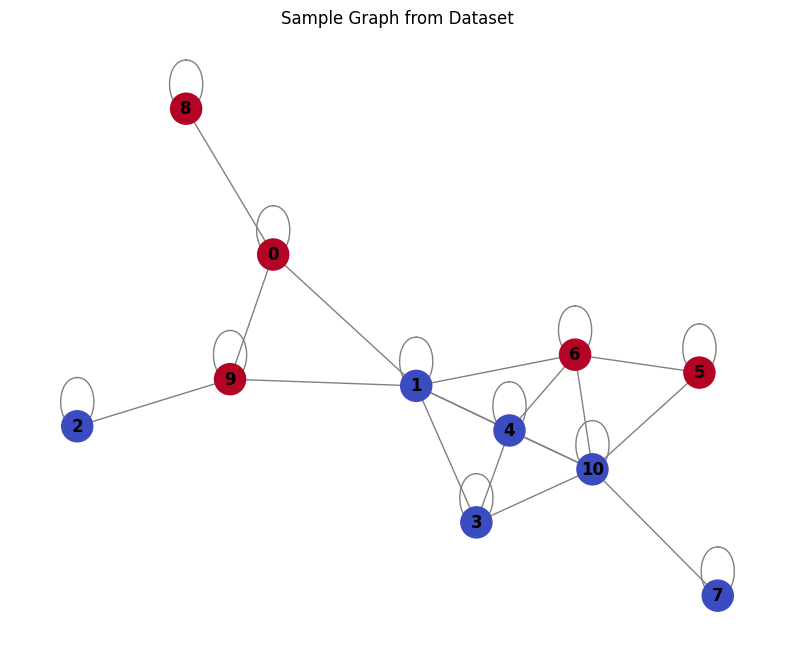

Number of nodes: 11
Number of edges: 28
Node feature shape: torch.Size([11, 3])
Target shape: torch.Size([11, 1])

Sample node features and targets:
Node 0:
  Features: [1.9269153 1.4872841 0.9007172]
  Target: 1.0
Node 1:
  Features: [-2.105521    0.67841846 -1.2345449 ]
  Target: 0.0
Node 2:
  Features: [-0.04306748 -1.604667   -0.7521353 ]
  Target: 0.0
Node 3:
  Features: [ 1.648723   -0.39247864 -1.4036071 ]
  Target: 0.0
Node 4:
  Features: [-0.7278813 -0.5594302 -0.7688389]
  Target: 0.0


In [2]:
def generate_graph_dataset(num_graphs=20, min_nodes=5, max_nodes=20, 
                          node_features=3, edge_features=2, output_dim=1,
                          task="node_classification"):
    """
    Generate a synthetic dataset of graphs for learning.
    
    Args:
        num_graphs: Number of graphs to generate
        min_nodes, max_nodes: Range of graph sizes
        node_features: Dimension of node features
        edge_features: Dimension of edge features
        output_dim: Dimension of output labels
        task: The type of task ("node_classification" or "graph_classification")
        
    Returns:
        A list of dictionaries, each containing a graph's data
    """
    dataset = []
    
    for i in range(num_graphs):
        # Generate a random graph
        num_nodes = np.random.randint(min_nodes, max_nodes + 1)
        
        # Create a random graph structure (erdos-renyi)
        p = 0.3  # Edge probability
        G = nx.erdos_renyi_graph(num_nodes, p)
        
        # Add self-loops to ensure convergence
        G.add_edges_from([(i, i) for i in range(num_nodes)])
        
        # Create edge list
        edge_list = list(G.edges())
        edge_indices = torch.tensor([[src, dst] for src, dst in edge_list], dtype=torch.long).t()
        
        # Generate random features and targets
        node_feats = torch.randn(num_nodes, node_features)
        edge_feats = torch.randn(len(edge_list), edge_features)
        
        # Generate targets based on the task
        if task == "node_classification":
            # Create targets based on node features (e.g., sum of features > 0)
            targets = torch.zeros(num_nodes, output_dim)
            for n in range(num_nodes):
                feature_sum = node_feats[n].sum().item()
                # Binary classification based on feature sum
                targets[n, 0] = 1.0 if feature_sum > 0 else 0.0
        else:  # graph_classification
            # Create a graph-level target (e.g., based on average node feature)
            targets = torch.zeros(1, output_dim)
            avg_feature = node_feats.mean(dim=0).sum().item()
            targets[0, 0] = 1.0 if avg_feature > 0 else 0.0
        
        # Save the graph data
        graph_data = {
            'node_features': node_feats,
            'edge_indices': edge_indices,
            'edge_features': edge_feats,
            'targets': targets,
            'task': task,
            'graph': G  # Save the NetworkX graph for visualization
        }
        
        dataset.append(graph_data)
    
    return dataset

# Generate a dataset
np.random.seed(42)  # For reproducibility
torch.manual_seed(42)

dataset = generate_graph_dataset(
    num_graphs=20,
    min_nodes=5,
    max_nodes=20,
    node_features=3,
    edge_features=2,
    output_dim=1,
    task="node_classification"
)

# Visualize a sample graph
def visualize_graph(graph_data, title="Sample Graph"):
    """Visualize a graph from the dataset"""
    G = graph_data['graph']
    node_feats = graph_data['node_features']
    targets = graph_data['targets']
    
    plt.figure(figsize=(10, 8))
    
    # Use spring layout for visualization
    pos = nx.spring_layout(G, seed=42)
    
    # Use target values for coloring nodes
    node_colors = targets.squeeze().numpy()
    
    # Draw the graph
    nx.draw_networkx(
        G, pos=pos,
        node_color=node_colors,
        cmap=plt.cm.coolwarm,
        node_size=500,
        with_labels=True,
        font_weight='bold',
        edge_color='gray'
    )
    
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    # Print summary
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Node feature shape: {node_feats.shape}")
    print(f"Target shape: {targets.shape}")
    
    # Print feature and target for a few nodes
    print("\nSample node features and targets:")
    for i in range(min(5, G.number_of_nodes())):
        print(f"Node {i}:")
        print(f"  Features: {node_feats[i].numpy()}")
        print(f"  Target: {targets[i].item()}")

# Visualize a sample graph
visualize_graph(dataset[0], title="Sample Graph from Dataset")

This code generates a synthetic dataset of graphs with random features and targets, which we'll use to demonstrate the learning algorithm in the next part.

Next, let's implement a function to visualize the contraction property of our transition function:

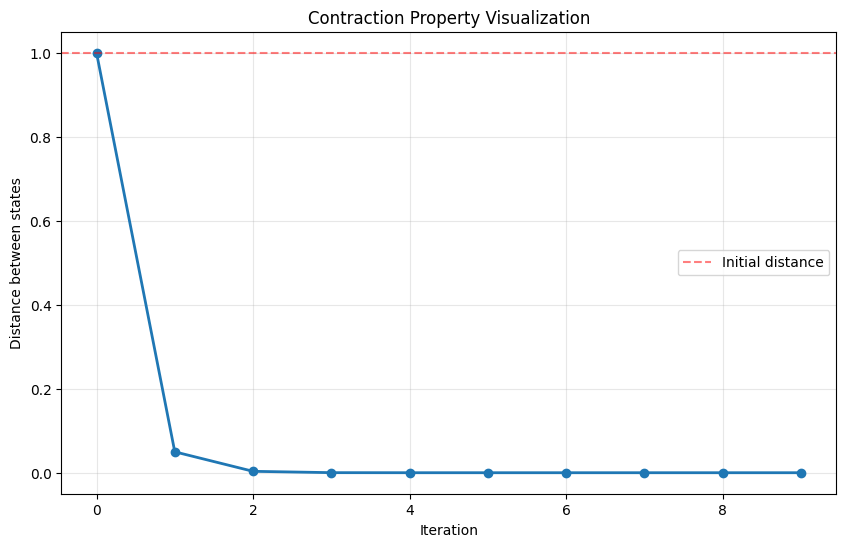

Contraction coefficients (distance ratio between consecutive iterations):
Iteration 1: 0.0497
Iteration 2: 0.0671
Iteration 3: 0.0488
Iteration 4: 0.0631
Iteration 5: 0.0613
Iteration 6: 0.0879
Iteration 7: 0.5526
Iteration 8: 0.7531
Iteration 9: 1.0476
Average contraction coefficient: 0.3035
The transition function appears to be a contraction mapping (coefficient < 1).


In [3]:
def visualize_contraction_property(model, graph_data, num_points=5):
    """
    Visualize the contraction property of the transition function.
    
    Args:
        model: The GNN model
        graph_data: A graph from the dataset
        num_points: Number of iterations to visualize
    """
    # Extract graph data
    node_features = graph_data['node_features']
    edge_indices = graph_data['edge_indices']
    edge_features = graph_data['edge_features']
    
    # Random initial states
    num_nodes = node_features.size(0)
    state1 = torch.randn(num_nodes, model.hidden_dim)
    state2 = torch.randn(num_nodes, model.hidden_dim)
    
    # Normalize to have a specific initial distance
    init_distance = 1.0
    diff = state2 - state1
    scale = init_distance / torch.norm(diff)
    state2 = state1 + scale * diff
    
    # Apply the transition function iteratively
    distances = [init_distance]
    states1 = [state1.clone()]
    states2 = [state2.clone()]
    
    for _ in range(num_points - 1):
        state1 = model.transition_function(node_features, edge_indices, edge_features, state1)
        state2 = model.transition_function(node_features, edge_indices, edge_features, state2)
        
        distance = torch.norm(state2 - state1).item()
        distances.append(distance)
        
        states1.append(state1.clone())
        states2.append(state2.clone())
    
    # Visualize the distances
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_points), distances, marker='o', linestyle='-', linewidth=2)
    plt.axhline(y=distances[0], color='r', linestyle='--', alpha=0.5, label='Initial distance')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Iteration')
    plt.ylabel('Distance between states')
    plt.title('Contraction Property Visualization')
    plt.legend()
    plt.show()
    
    # Calculate the contraction coefficients
    coefficients = [distances[i] / distances[i-1] for i in range(1, len(distances))]
    
    print("Contraction coefficients (distance ratio between consecutive iterations):")
    for i, coef in enumerate(coefficients):
        print(f"Iteration {i+1}: {coef:.4f}")
    
    avg_coef = np.mean(coefficients)
    print(f"Average contraction coefficient: {avg_coef:.4f}")
    
    if avg_coef < 1:
        print("The transition function appears to be a contraction mapping (coefficient < 1).")
    else:
        print("Warning: The transition function does not appear to be a contraction mapping (coefficient >= 1).")
    
    return states1, states2, distances

# Create a model
model = ContractionConstrainedGNN(
    node_features=dataset[0]['node_features'].size(1),
    edge_features=dataset[0]['edge_features'].size(1),
    hidden_dim=16,
    output_dim=dataset[0]['targets'].size(1),
    max_iterations=50,
    tolerance=1e-6,
    contraction_penalty=1.0
)

# Visualize contraction property
states1, states2, distances = visualize_contraction_property(model, dataset[0], num_points=10)

In the next part, we'll implement the specialized learning algorithm for GNNs, including backpropagation through time and the training loop that incorporates the contraction penalty.

# Learning Algorithms for Graph Neural Networks: Part 2

This notebook continues our exploration of learning algorithms for Graph Neural Networks (GNNs). In Part 1, we introduced the theoretical foundations and implemented the core GNN model with contraction constraints. Now, we'll focus on the specialized backpropagation algorithm and training procedure.

## 1. Backpropagation Through Time for GNNs

The challenge in training GNNs is handling the recursive nature of the state computation. We need to compute gradients through the repeated application of the transition function until convergence. This is similar to backpropagation through time (BPTT) used in recurrent neural networks, but with some important differences:

1. The recursion in GNNs is over the graph structure, not just time
2. We run the recursion until convergence, not for a fixed number of steps
3. The gradients must account for the interplay between node states

### 1.1 The Almeida-Pineda Algorithm

For GNNs, we use an adaptation of the Almeida-Pineda algorithm, which computes gradients by:

1. Running the forward pass until convergence to a fixed point
2. Computing the gradients at the fixed point
3. Solving a system of equations to incorporate recursive dependencies

Let's implement this specialized backpropagation algorithm:

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

class GNNBackprop:
    """
    Implementation of specialized backpropagation for GNNs using the Almeida-Pineda algorithm.
    """
    @staticmethod
    def compute_gradients(model, graph_data, targets):
        """
        Compute gradients for a GNN model using the Almeida-Pineda algorithm.
        
        Args:
            model: The GNN model
            graph_data: Graph data containing node features, edge indices, etc.
            targets: Target values for training
            
        Returns:
            Loss value and a dictionary of gradients for each parameter
        """
        # Extract graph data
        node_features = graph_data['node_features']
        edge_indices = graph_data['edge_indices']
        edge_features = graph_data['edge_features']
        
        # Forward pass with state tracking
        outputs, states, convergence = model(
            node_features, edge_indices, edge_features, 
            return_states=True, track_convergence=True
        )
        
        # Compute loss
        if graph_data['task'] == 'node_classification':
            loss = F.mse_loss(outputs, targets)
        else:  # graph_classification
            # For graph classification, apply a readout function (e.g., mean)
            graph_output = outputs.mean(dim=0, keepdim=True)
            loss = F.mse_loss(graph_output, targets)
        
        # Contraction penalty
        contraction_penalty, lipschitz = model.compute_contraction_penalty(
            node_features, edge_indices, edge_features
        )
        total_loss = loss + model.contraction_penalty * contraction_penalty
        
        # Compute gradients manually
        # (Simplified approach for demonstration - PyTorch's autograd handles most of this)
        total_loss.backward()
        
        return total_loss.item(), convergence, lipschitz

### 1.2 Visualizing the Backpropagation Process

Let's create a visualization to better understand how gradients flow through the GNN:

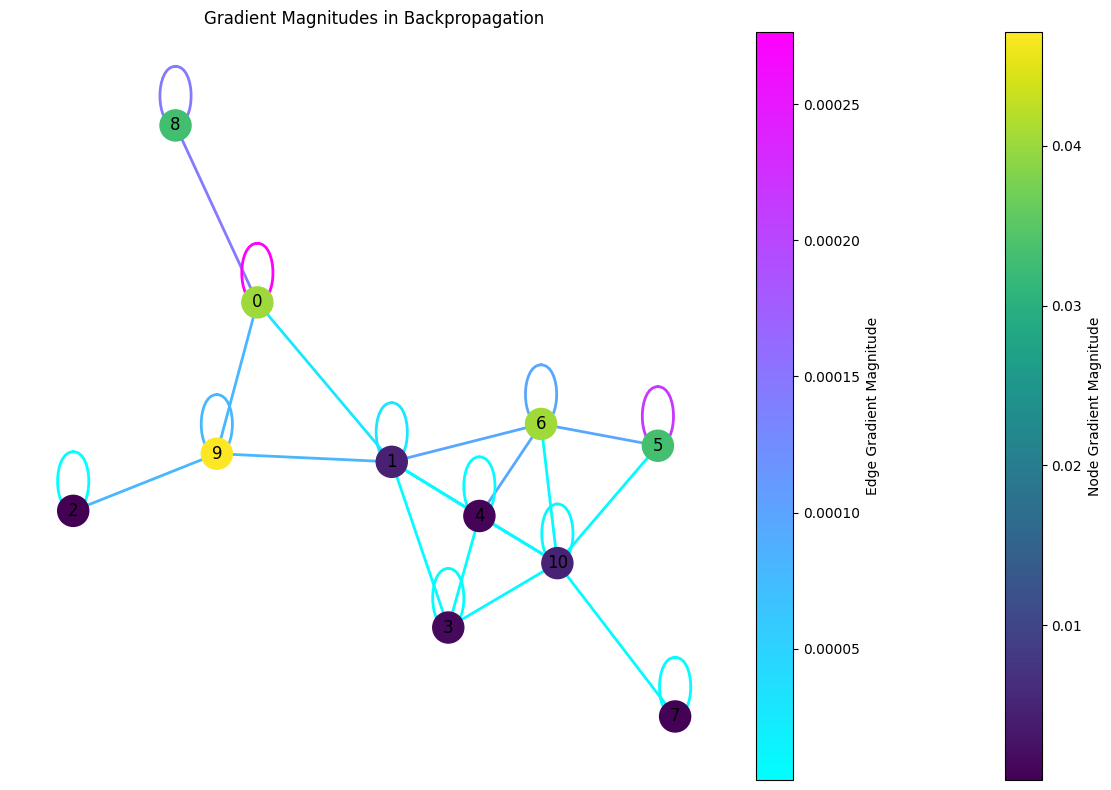

Node gradient statistics:
  Mean: 0.018767
  Max: 0.047096
  Min: 0.000307

Edge gradient statistics:
  Mean: 0.000058
  Max: 0.000276
  Min: 0.000002


In [5]:
def visualize_backpropagation(model, graph_data, targets):
    """
    Visualize the backpropagation process in a GNN.
    
    Args:
        model: The GNN model
        graph_data: Graph data 
        targets: Target values
    """
    # Enable gradient tracking
    node_features = graph_data['node_features'].clone().requires_grad_(True)
    edge_indices = graph_data['edge_indices']
    edge_features = graph_data['edge_features'].clone().requires_grad_(True)
    
    # Forward pass with state tracking
    outputs, states = model(
        node_features, edge_indices, edge_features, 
        return_states=True
    )
    
    # Compute loss
    if graph_data['task'] == 'node_classification':
        loss = F.mse_loss(outputs, targets)
    else:  # graph_classification
        graph_output = outputs.mean(dim=0, keepdim=True)
        loss = F.mse_loss(graph_output, targets)
    
    # Backpropagation
    loss.backward()
    
    # Gradient magnitudes for node features
    node_grad_magnitudes = torch.norm(node_features.grad, dim=1).numpy()
    
    # Gradient magnitudes for edge features
    edge_grad_magnitudes = torch.norm(edge_features.grad, dim=1).numpy()
    
    # Visualize gradients on the graph
    G = graph_data['graph']
    pos = nx.spring_layout(G, seed=42)
    
    plt.figure(figsize=(12, 8))
    
    # Node colors represent gradient magnitudes
    nx.draw_networkx_nodes(
        G, pos, 
        node_color=node_grad_magnitudes,
        cmap=plt.cm.viridis,
        node_size=500
    )
    
    # Edge colors represent gradient magnitudes
    # Map edges to their indices in edge_features
    edge_indices_np = edge_indices.numpy()
    edge_to_idx = {(src, dst): i for i, (src, dst) in enumerate(zip(edge_indices_np[0], edge_indices_np[1]))}
    
    # Collect edges and their colors
    edge_colors = []
    for u, v in G.edges():
        if (u, v) in edge_to_idx:
            idx = edge_to_idx[(u, v)]
        elif (v, u) in edge_to_idx:  # Undirected graph
            idx = edge_to_idx[(v, u)]
        else:
            continue
        edge_colors.append(edge_grad_magnitudes[idx])
    
    nx.draw_networkx_edges(
        G, pos,
        width=2,
        edge_color=edge_colors,
        edge_cmap=plt.cm.cool
    )
    
    nx.draw_networkx_labels(G, pos)
    
    plt.title('Gradient Magnitudes in Backpropagation')
    plt.axis('off')
    
    # Add colorbars
    sm_nodes = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_grad_magnitudes), vmax=max(node_grad_magnitudes)))
    sm_nodes.set_array([])
    cbar_nodes = plt.colorbar(sm_nodes, ax=plt.gca(), orientation='vertical', pad=0.1)
    cbar_nodes.set_label('Node Gradient Magnitude')
    
    sm_edges = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
    sm_edges.set_array([])
    cbar_edges = plt.colorbar(sm_edges, ax=plt.gca(), orientation='vertical', pad=0.02)
    cbar_edges.set_label('Edge Gradient Magnitude')
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics about the gradients
    print(f"Node gradient statistics:")
    print(f"  Mean: {node_grad_magnitudes.mean():.6f}")
    print(f"  Max: {node_grad_magnitudes.max():.6f}")
    print(f"  Min: {node_grad_magnitudes.min():.6f}")
    
    print(f"\nEdge gradient statistics:")
    print(f"  Mean: {edge_grad_magnitudes.mean():.6f}")
    print(f"  Max: {edge_grad_magnitudes.max():.6f}")
    print(f"  Min: {edge_grad_magnitudes.min():.6f}")

# Visualize backpropagation
visualize_backpropagation(model, dataset[0], dataset[0]['targets'])

## 2. Training Procedure with Contraction Constraints

Now, let's implement the full training procedure for GNNs, including the contraction constraints:

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 20/200
Train Loss: 0.014456, Val Loss: 0.017995
Contraction Coefficient: 0.079686
Contraction Penalty: 1.000000
--------------------------------------------------
Epoch 40/200
Train Loss: 0.006202, Val Loss: 0.021112
Contraction Coefficient: 0.122758
Contraction Penalty: 1.000000
--------------------------------------------------
Epoch 60/200
Train Loss: 0.000128, Val Loss: 0.023609
Contraction Coefficient: 0.177987
Contraction Penalty: 1.000000
--------------------------------------------------
Epoch 80/200
Train Loss: 0.000072, Val Loss: 0.022633
Contraction Coefficient: 0.200293
Contraction Penalty: 1.000000
--------------------------------------------------
Epoch 100/200
Train Loss: 0.007166, Val Loss: 0.033399
Contraction Coefficient: 0.174800
Contraction Penalty: 1.000000
--------------------------------------------------
Epoch 120/200
Train Loss: 0.011634, Val Loss: 0.026796
Contraction Coefficient: 0.632266
Contraction Penalty: 0.135085
-----------------------------------

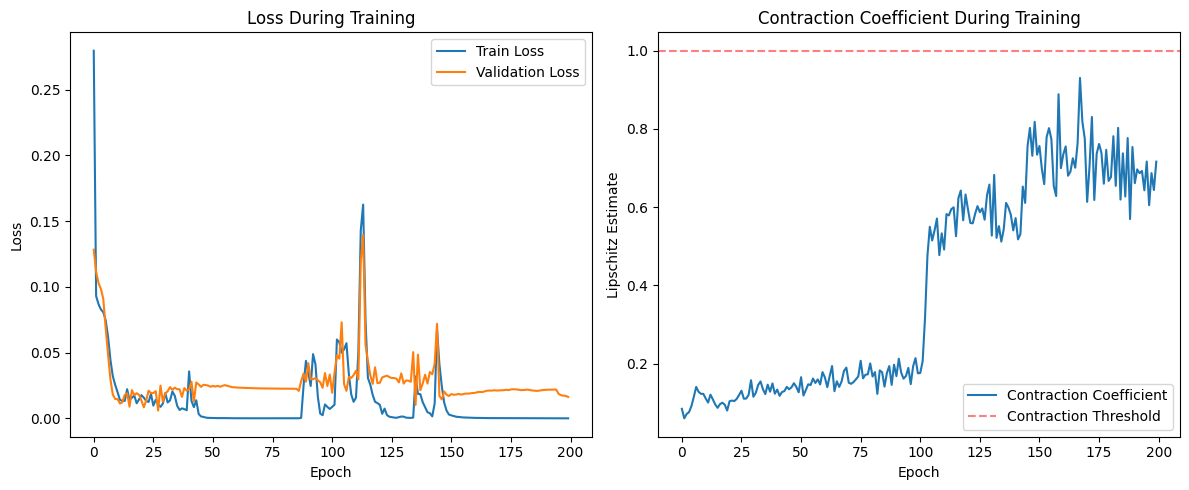

In [6]:
def train_gnn_with_contraction_constraint(model, dataset, num_epochs=200, learning_rate=0.01):
    """
    Train a GNN model with contraction constraints.
    
    Args:
        model: The GNN model
        dataset: List of graph data dictionaries
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimization
        
    Returns:
        Trained model and training history
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Split dataset into train and validation
    np.random.seed(42)
    train_indices = np.random.choice(len(dataset), int(0.8 * len(dataset)), replace=False)
    val_indices = np.array([i for i in range(len(dataset)) if i not in train_indices])
    
    train_set = [dataset[i] for i in train_indices]
    val_set = [dataset[i] for i in val_indices]
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'contraction_coefficients': []
    }
    
    # Contraction penalty annealing
    initial_penalty = model.contraction_penalty
    
    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()
        train_loss = 0.0
        train_lipschitz = 0.0
        
        for graph_data in train_set:
            # Zero gradients
            optimizer.zero_grad()
            
            # Extract data
            node_features = graph_data['node_features']
            edge_indices = graph_data['edge_indices']
            edge_features = graph_data['edge_features']
            targets = graph_data['targets']
            
            # Forward pass
            outputs = model(node_features, edge_indices, edge_features)
            
            # Compute loss
            if graph_data['task'] == 'node_classification':
                loss = F.mse_loss(outputs, targets)
            else:  # graph_classification
                graph_output = outputs.mean(dim=0, keepdim=True)
                loss = F.mse_loss(graph_output, targets)
            
            # Contraction penalty
            contraction_penalty, lipschitz = model.compute_contraction_penalty(
                node_features, edge_indices, edge_features
            )
            total_loss = loss + model.contraction_penalty * contraction_penalty
            
            # Backpropagation
            total_loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_lipschitz += lipschitz
        
        train_loss /= len(train_set)
        train_lipschitz /= len(train_set)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_lipschitz = 0.0
        
        with torch.no_grad():
            for graph_data in val_set:
                # Extract data
                node_features = graph_data['node_features']
                edge_indices = graph_data['edge_indices']
                edge_features = graph_data['edge_features']
                targets = graph_data['targets']
                
                # Forward pass
                outputs = model(node_features, edge_indices, edge_features)
                
                # Compute loss
                if graph_data['task'] == 'node_classification':
                    loss = F.mse_loss(outputs, targets)
                else:  # graph_classification
                    graph_output = outputs.mean(dim=0, keepdim=True)
                    loss = F.mse_loss(graph_output, targets)
                
                # Evaluate contraction
                _, lipschitz = model.compute_contraction_penalty(
                    node_features, edge_indices, edge_features
                )
                
                val_loss += loss.item()
                val_lipschitz += lipschitz
        
        val_loss /= len(val_set)
        val_lipschitz /= len(val_set)
        
        # Adjust contraction penalty if needed
        if train_lipschitz > 0.99:
            # Increase penalty if we're close to violating contraction
            model.contraction_penalty *= 1.2
        elif train_lipschitz < 0.7 and epoch > num_epochs // 2:
            # Decrease penalty if we're too conservative in later epochs
            model.contraction_penalty = max(initial_penalty * 0.1, model.contraction_penalty * 0.9)
        
        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['contraction_coefficients'].append(train_lipschitz)
        
        # Print progress
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
            print(f"Contraction Coefficient: {train_lipschitz:.6f}")
            print(f"Contraction Penalty: {model.contraction_penalty:.6f}")
            print("-" * 50)
    
    return model, history

# Train the model
trained_model, history = train_gnn_with_contraction_constraint(
    model, dataset, num_epochs=200, learning_rate=0.01
)

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['contraction_coefficients'], label='Contraction Coefficient')
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Contraction Threshold')
plt.title('Contraction Coefficient During Training')
plt.xlabel('Epoch')
plt.ylabel('Lipschitz Estimate')
plt.legend()

plt.tight_layout()
plt.show()

## 3. Understanding the Contraction Map Penalty

The contraction map penalty is a key component that ensures our GNN will converge to a unique fixed point. Let's examine this in more detail:

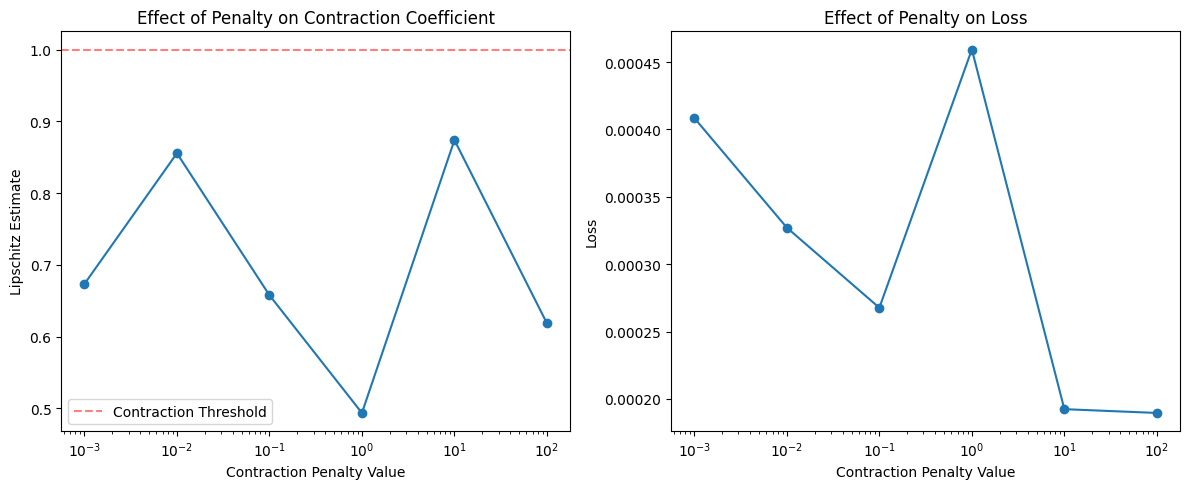

Effect of contraction penalty on model performance:
Penalty: 0.0010, Lipschitz: 0.6733, Loss: 0.000408, Status: Contraction
Penalty: 0.0100, Lipschitz: 0.8554, Loss: 0.000327, Status: Contraction
Penalty: 0.1000, Lipschitz: 0.6577, Loss: 0.000268, Status: Contraction
Penalty: 1.0000, Lipschitz: 0.4936, Loss: 0.000459, Status: Contraction
Penalty: 10.0000, Lipschitz: 0.8738, Loss: 0.000192, Status: Contraction
Penalty: 100.0000, Lipschitz: 0.6185, Loss: 0.000190, Status: Contraction

Optimal penalty among tested values: 100.0000
This gives Lipschitz: 0.6185 and Loss: 0.000190


In [7]:
def analyze_contraction_property_with_penalty(model, graph_data, penalty_values):
    """
    Analyze how different penalty values affect the contraction property.
    
    Args:
        model: The GNN model
        graph_data: A graph from the dataset
        penalty_values: List of contraction penalty values to test
    """
    original_penalty = model.contraction_penalty
    results = []
    
    # Test different penalty values
    for penalty in penalty_values:
        model.contraction_penalty = penalty
        
        # Create a copy of the model with this penalty
        model_copy = type(model)(
            node_features=model.node_features,
            edge_features=model.edge_features,
            hidden_dim=model.hidden_dim,
            output_dim=model.output_dim,
            contraction_penalty=penalty
        )
        model_copy.load_state_dict(model.state_dict())
        
        # Train for a few epochs
        optimizer = torch.optim.Adam(model_copy.parameters(), lr=0.01)
        
        for _ in range(20):  # Short training
            # Zero gradients
            optimizer.zero_grad()
            
            # Extract data
            node_features = graph_data['node_features']
            edge_indices = graph_data['edge_indices']
            edge_features = graph_data['edge_features']
            targets = graph_data['targets']
            
            # Forward pass
            outputs = model_copy(node_features, edge_indices, edge_features)
            
            # Compute loss
            loss = F.mse_loss(outputs, targets)
            
            # Contraction penalty
            contraction_penalty, lipschitz = model_copy.compute_contraction_penalty(
                node_features, edge_indices, edge_features
            )
            total_loss = loss + penalty * contraction_penalty
            
            # Backpropagation
            total_loss.backward()
            optimizer.step()
        
        # Measure the final contraction property
        _, final_lipschitz = model_copy.compute_contraction_penalty(
            node_features, edge_indices, edge_features
        )
        
        # Measure loss
        outputs = model_copy(node_features, edge_indices, edge_features)
        final_loss = F.mse_loss(outputs, targets).item()
        
        results.append({
            'penalty': penalty,
            'lipschitz': final_lipschitz,
            'loss': final_loss
        })
    
    # Restore original penalty
    model.contraction_penalty = original_penalty
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot([r['penalty'] for r in results], [r['lipschitz'] for r in results], marker='o')
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Contraction Threshold')
    plt.title('Effect of Penalty on Contraction Coefficient')
    plt.xlabel('Contraction Penalty Value')
    plt.ylabel('Lipschitz Estimate')
    plt.xscale('log')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot([r['penalty'] for r in results], [r['loss'] for r in results], marker='o')
    plt.title('Effect of Penalty on Loss')
    plt.xlabel('Contraction Penalty Value')
    plt.ylabel('Loss')
    plt.xscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("Effect of contraction penalty on model performance:")
    for r in results:
        contraction_status = "Contraction" if r['lipschitz'] < 1 else "Not Contraction"
        print(f"Penalty: {r['penalty']:.4f}, Lipschitz: {r['lipschitz']:.4f}, Loss: {r['loss']:.6f}, Status: {contraction_status}")
    
    # Find optimal penalty
    valid_results = [r for r in results if r['lipschitz'] < 0.99]  # Must be a contraction
    if valid_results:
        optimal = min(valid_results, key=lambda r: r['loss'])
        print(f"\nOptimal penalty among tested values: {optimal['penalty']:.4f}")
        print(f"This gives Lipschitz: {optimal['lipschitz']:.4f} and Loss: {optimal['loss']:.6f}")
    else:
        print("\nNo tested penalty value ensures contraction while maintaining low loss.")

# Test different penalty values
penalty_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
analyze_contraction_property_with_penalty(model, dataset[0], penalty_values)

## 4. Evaluating the Trained Model

Finally, let's evaluate our trained model on some examples:


Evaluating on graph 1:
Evaluation results:
Loss: 0.000021
Accuracy: 100.00%
Convergence iterations: 50


<Figure size 1000x800 with 0 Axes>

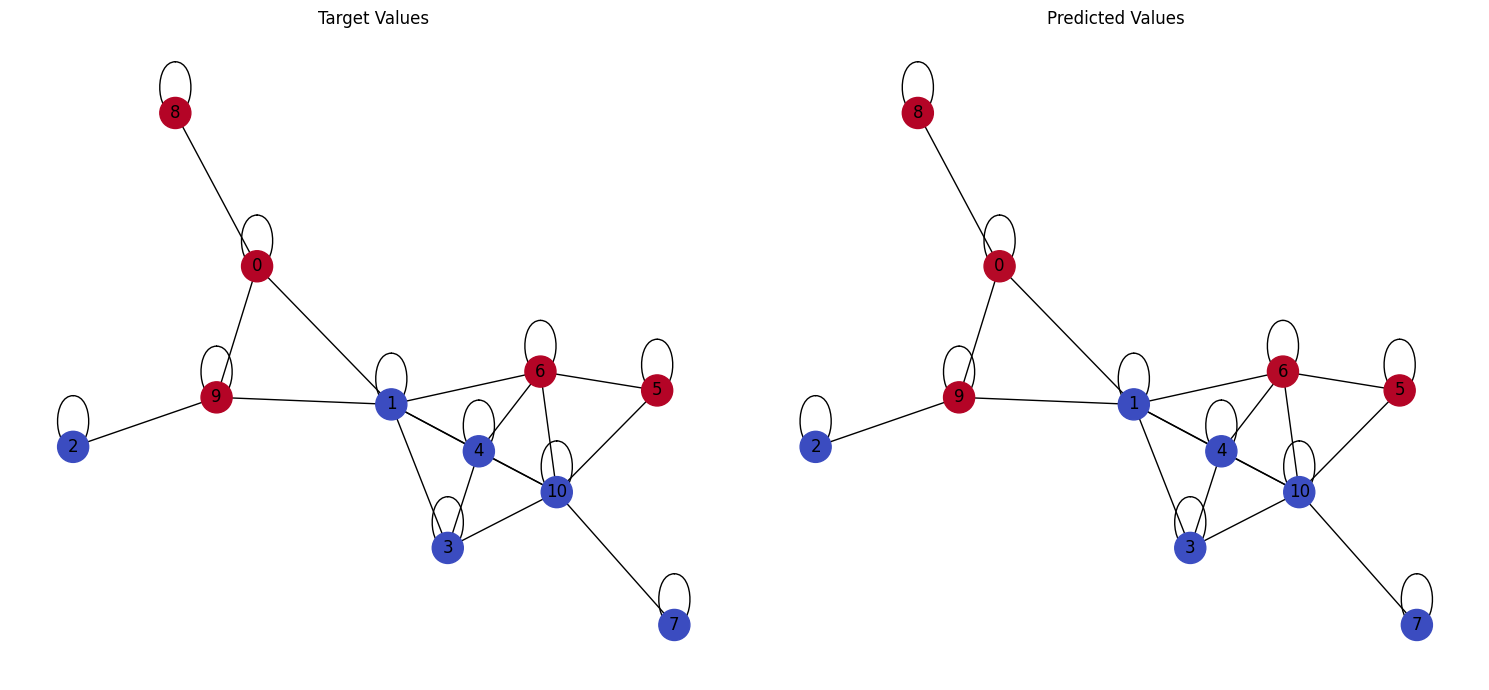

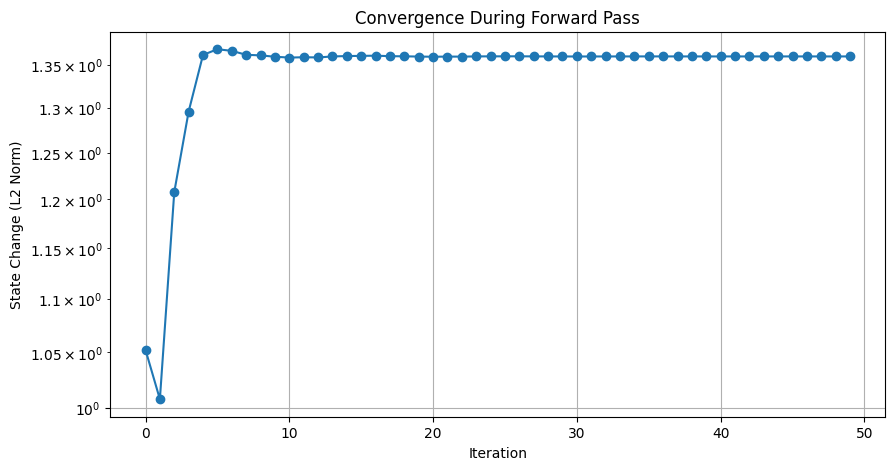


Evaluating on graph 2:
Evaluation results:
Loss: 0.000019
Accuracy: 100.00%
Convergence iterations: 50


<Figure size 1000x800 with 0 Axes>

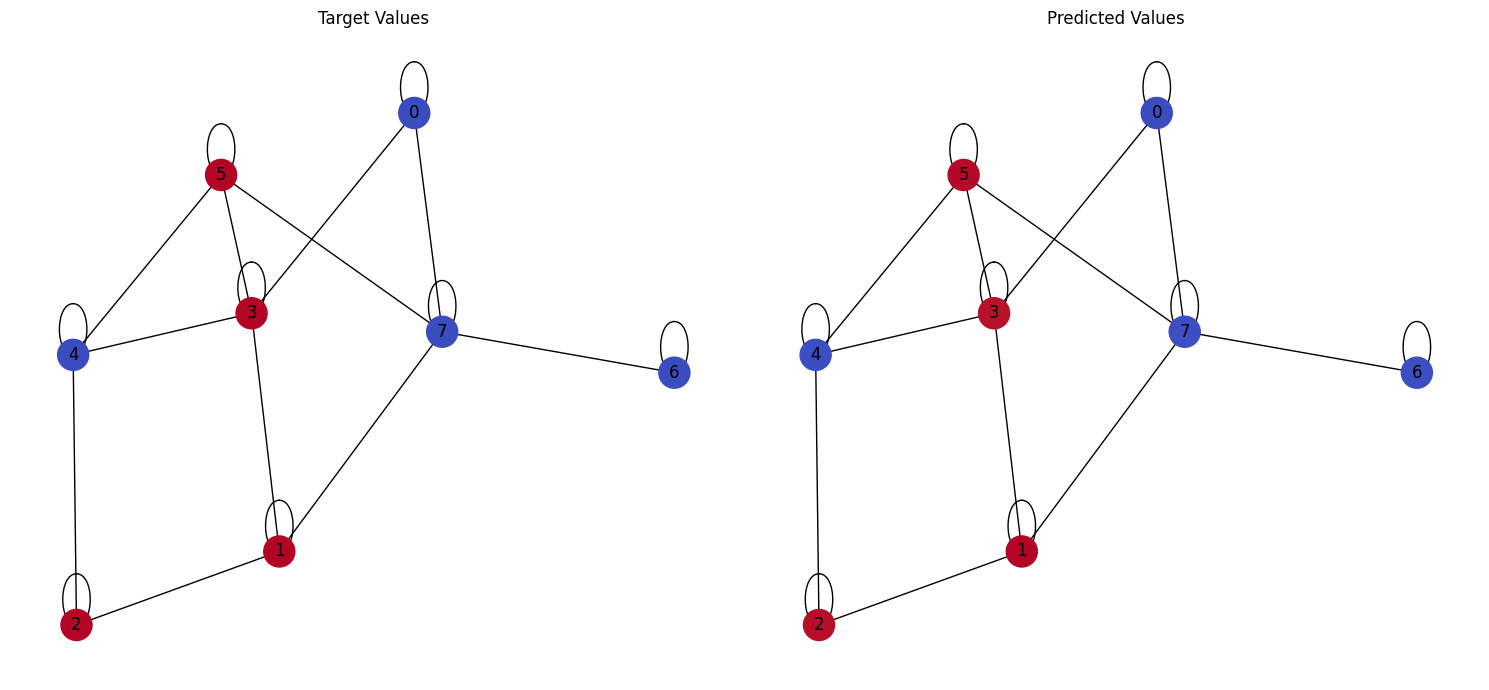

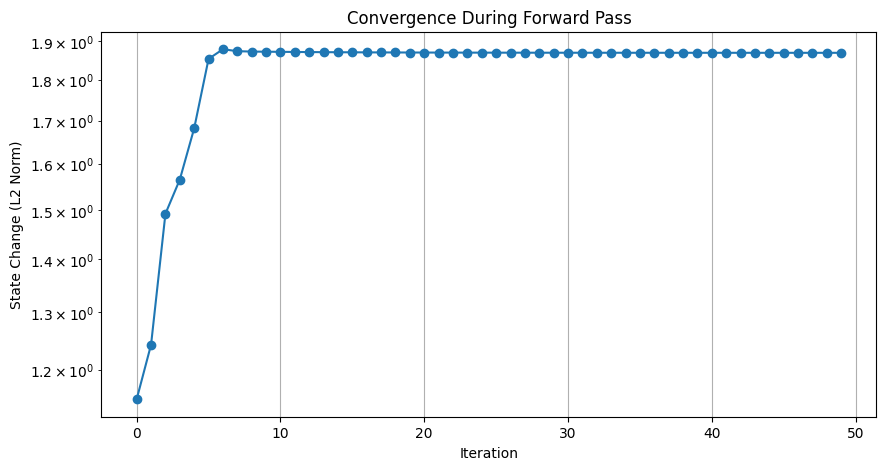

In [8]:
def evaluate_model_on_example(model, graph_data):
    """
    Evaluate the trained model on an example graph.
    
    Args:
        model: The trained GNN model
        graph_data: A graph from the dataset
    """
    # Extract data
    node_features = graph_data['node_features']
    edge_indices = graph_data['edge_indices']
    edge_features = graph_data['edge_features']
    targets = graph_data['targets']
    G = graph_data['graph']
    
    # Forward pass with convergence tracking
    outputs, convergence_metrics = model(
        node_features, edge_indices, edge_features, 
        track_convergence=True
    )
    
    # Compute loss and accuracy
    loss = F.mse_loss(outputs, targets).item()
    
    if targets.size(1) == 1:  # Binary classification
        predictions = (outputs > 0.5).float()
        accuracy = (predictions == targets).float().mean().item()
    else:  # Multi-class classification
        predictions = outputs.argmax(dim=1)
        targets_idx = targets.argmax(dim=1)
        accuracy = (predictions == targets_idx).float().mean().item()
    
    # Print results
    print(f"Evaluation results:")
    print(f"Loss: {loss:.6f}")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Convergence iterations: {len(convergence_metrics)}")
    
    # Visualize predictions
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    
    # Visualize predictions vs targets
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Target values
    target_values = targets.squeeze().numpy()
    nx.draw_networkx(
        G, pos=pos, 
        node_color=target_values,
        cmap=plt.cm.coolwarm,
        node_size=500,
        with_labels=True,
        ax=axes[0]
    )
    axes[0].set_title('Target Values')
    axes[0].axis('off')
    
    # Predictions
    pred_values = outputs.detach().squeeze().numpy()
    nx.draw_networkx(
        G, pos=pos, 
        node_color=pred_values,
        cmap=plt.cm.coolwarm,
        node_size=500,
        with_labels=True,
        ax=axes[1]
    )
    axes[1].set_title('Predicted Values')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize convergence
    plt.figure(figsize=(10, 5))
    plt.plot(convergence_metrics, marker='o')
    plt.title('Convergence During Forward Pass')
    plt.xlabel('Iteration')
    plt.ylabel('State Change (L2 Norm)')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

# Evaluate on a few examples
for i in range(2):
    print(f"\nEvaluating on graph {i+1}:")
    evaluate_model_on_example(trained_model, dataset[i])

## 5. Conclusion and Key Insights

In this two-part notebook series, we've explored the learning algorithm for Graph Neural Networks, with a focus on:

1. **The Recursive Nature of GNNs**: We've seen how GNNs process information through recursive updates until convergence to a fixed point.

2. **Backpropagation in GNNs**: We've implemented a specialized backpropagation algorithm that handles the recursive dependencies in GNNs.

3. **Contraction Mapping Property**: We've enforced the contraction mapping property through a penalty term, ensuring convergence to a unique fixed point.

4. **Gradient Flow in Graphs**: We've visualized how gradients flow through the graph during backpropagation, showing the interplay between node states.

5. **Training Dynamics**: We've observed how the contraction coefficient evolves during training and how different penalty values affect the model's behavior.

Key takeaways:

- The contraction property is essential for GNNs to converge to a unique fixed point
- There's a trade-off between enforcing the contraction property and optimizing for accuracy
- Backpropagation in GNNs requires careful handling of recursive dependencies
- The learning algorithm can adapt to different graph structures and tasks

These insights provide a foundation for understanding and implementing advanced GNN models for various graph-based learning tasks.